In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import multivariate_normal
import seaborn as sns

warnings.filterwarnings("ignore")

### 1. Скачайте данные в формате csv

In [2]:
data_path = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
days_delta = 50
date_start = '2020-03-03'
date_end = '2021-12-03'


In [3]:
df = pd.read_csv(data_path)

In [4]:
df = df[df['iso_code'] == 'RUS']
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= date_start]
df = df[df['date'] <= date_end]
df['new_cases'][df['new_cases'] == 0] = 1
df.reset_index(drop=True, inplace=True)
df['day'] = df.reset_index()['index']
df['new_cases'][30] = df['new_cases'][29] # Похоже на выброс, заменил ближайшим

In [5]:
target_col = ['total_cases'] # 'total_cases', new_cases
feature_cols = ['day']

In [6]:
X = df[feature_cols]
y = df[target_col]

X_train = X[:days_delta]
y_train = y[:days_delta]

X_test = X[days_delta:]
y_test = y[days_delta:]

### 2. Постройте графики целевых переменных

<AxesSubplot:title={'center':'new_cases'}>

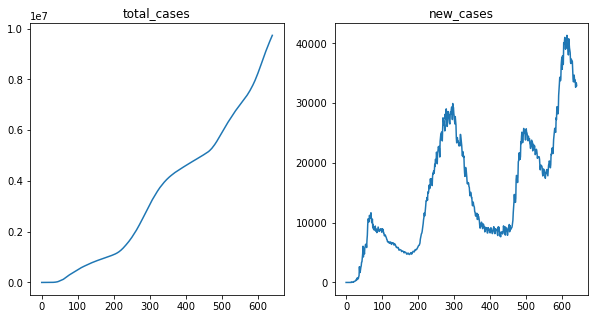

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
df['total_cases'].plot(ax=ax[0], title='total_cases')
df['new_cases'].plot(ax=ax[1], title='new_cases')

#### 2.a линейная регрессия с экспоненциальным ростом числа заболевших

In [8]:
model = LinearRegression()
model.fit(X_train, np.log(y_train))

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds = np.concatenate([preds_train, preds_test])
preds = np.exp(preds)

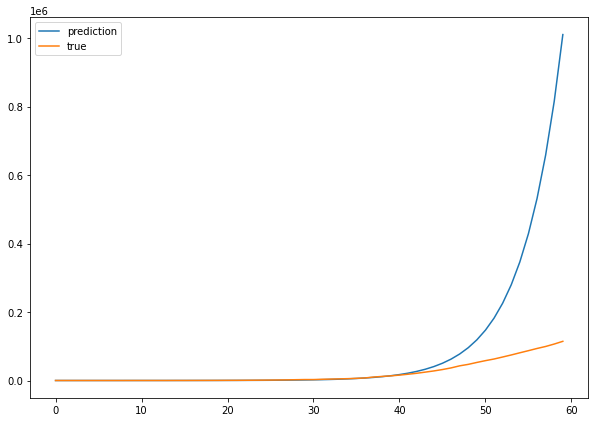

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(preds[:60], label='prediction')
ax.plot(y[:60], label='true')
ax.legend();

Видно, что эспонента плохо описывает целевую зависимость.

#### 2.b апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [10]:
model_weights = np.append(model.coef_[0], model.intercept_[0])
sigma_noise = (np.log(y_train) - preds_train).std().values[0]
print('Отклонение шума:', sigma_noise)
print('Веса модели', model_weights)


Отклонение шума: 0.45445743827575275
Веса модели [0.21410637 1.19341928]


In [11]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x = np.concatenate((x, np.array([[1]])), axis=1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [12]:
cur_mu, cur_sigma = np.zeros(model_weights.shape[0]), np.eye(model_weights.shape[0]) * 100

for i in range(0, 50):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train.iloc[i:i+1], np.log(y_train.iloc[i]), sigma_noise=sigma_noise)
cur_mu, cur_sigma

(array([0.21411212, 1.19322896]),
 array([[ 1.98325990e-05, -4.85878605e-04],
        [-4.85878605e-04,  1.60339948e-02]]))

Заметим, что параметры баесовской модели и линейной регрессии совпали.

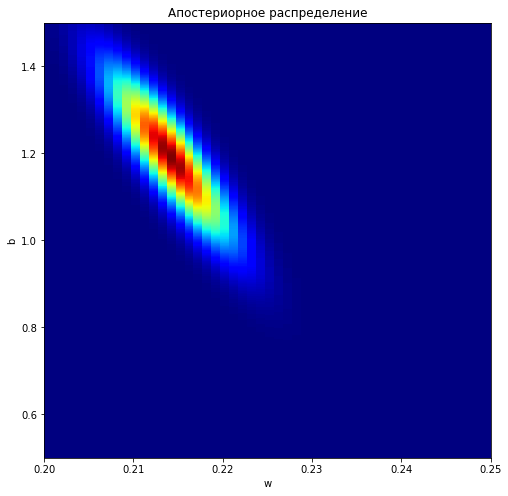

In [13]:
N = 1000
xs = np.linspace(0, 60, N)
X = np.linspace(0, 1, N)
Y = np.linspace(0.5, 1.5, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

plt.figure(figsize=(8, 8))
plt.xlim((0.2, 0.25))
plt.ylim((0.5, 1.5))
plt.xlabel('w')
plt.ylabel('b')
plt.title('Апостериорное распределение')
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.show()

#### 2.c графики сэмплов разных экспонент

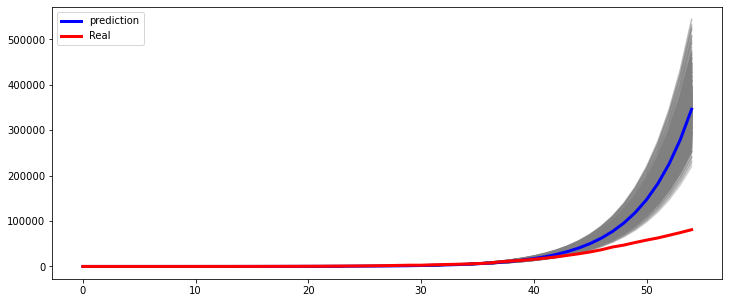

In [14]:
N_SAMPLES = 1000

plt.figure(figsize=(12, 5))
samples = np.random.multivariate_normal(cur_mu, cur_sigma, N_SAMPLES)
samples_preds = []
for (*w, b) in samples:
    model.coef_ = np.array(w)
    model.intercept_ = b
    sample_preds_train = model.predict(X_train)
    sample_preds_test = model.predict(X_test)
    sample_preds = np.concatenate([sample_preds_train, sample_preds_test])
    sample_preds = np.exp(sample_preds)
    samples_preds.append(sample_preds)
    plt.plot(sample_preds[:55], c='grey', alpha=0.3)

samples_preds = np.array(samples_preds)
plt.plot(preds[:55], color='blue', linewidth=3, label='prediction')
plt.plot(y[:55], color='red', linewidth=3, label='Real')
plt.legend();

#### Разброс предсказаний

1 мая 1029733 случаев
1 июня 814418778 случаев
1 сентября 367824425147040256 случаев


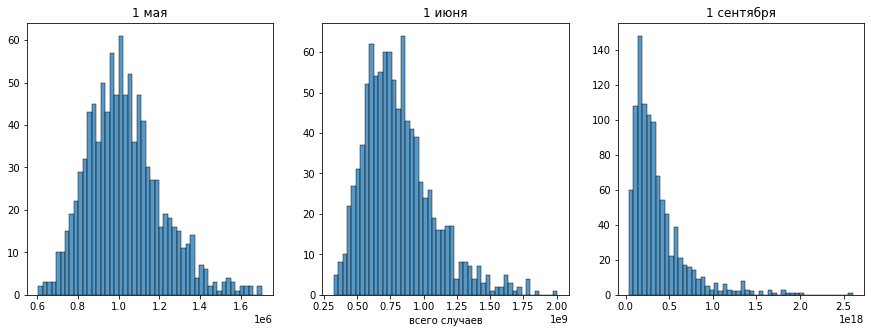

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
day_1 = pd.Timestamp('2020-05-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_1.days], bins=50, ax=ax[0]).set(title='1 мая', ylabel=None)

day_2 = pd.Timestamp('2020-06-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_2.days], bins=50, ax=ax[1]).set(title='1 июня', xlabel='всего случаев', ylabel=None)

day_3 = pd.Timestamp('2020-09-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_3.days], bins=50, ax=ax[2]).set(title='1 сентября', ylabel=None);

print(f'1 мая {int(samples_preds[:, day_1.days].mean().round())} случаев')
print(f'1 июня {int(samples_preds[:, day_2.days].mean().round())} случаев')
print(f'1 сентября {int(samples_preds[:, day_3.days].mean().round())} случаев')

### 3. Сигмоида
#### 3.a способ обучать параметры сигмоидальной функции припомощи линейной регрессии
Так как Ф(x) моделирует total_cases, то Ф'(x) моделирует new_cases. Поэтому обучим полином второй степени ln(y) = ax^2 + bx + c
#### 3.b обученная модель и апостериорное распределение

In [16]:
X_train = np.concatenate((X_train, X_train ** 2), axis=1)
X_test = np.concatenate((X_test, X_test ** 2), axis=1)

target_col = ['new_cases']
y = df[target_col]
y_train = y[:days_delta]

In [17]:
model = LinearRegression()
model.fit(X_train, np.log(y_train))
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds = np.concatenate([preds_train, preds_test])

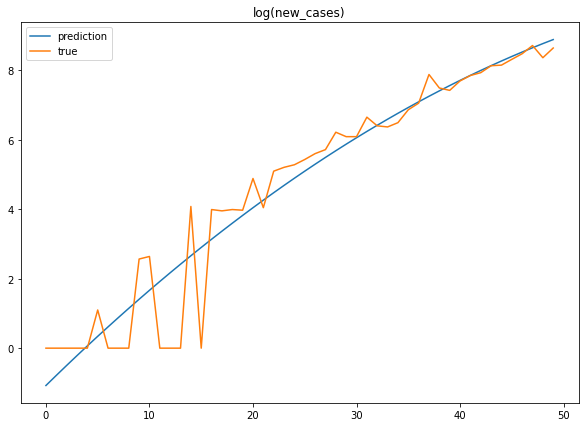

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(preds[:50], label='prediction')
ax.plot(np.log(y[:50]), label='true')
ax.set_title('log(new_cases)')
ax.legend();

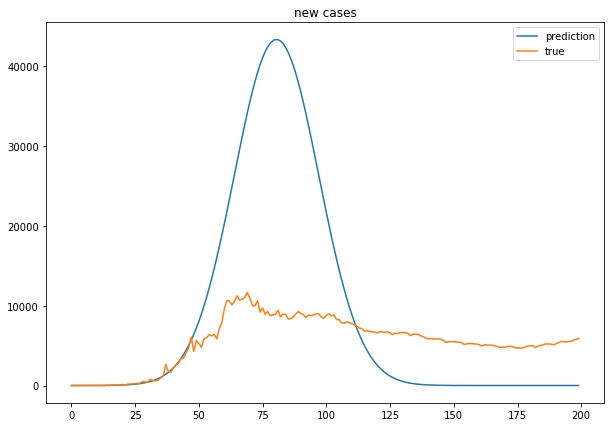

In [19]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.exp(preds[:200]), label='prediction')
ax.plot(y[:200], label='true')
ax.set_title('new cases')
ax.legend();

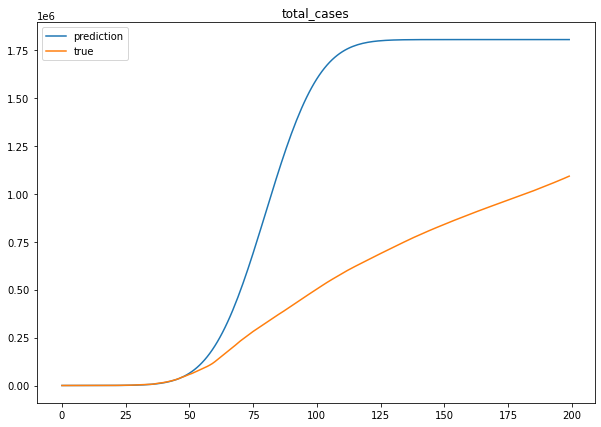

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.cumsum(np.exp(preds[:200])), label='prediction')
ax.plot(df['total_cases'][:200], label='true')
ax.set_title('total_cases')
ax.legend();

In [21]:
model_weights = np.append(model.coef_[0], model.intercept_[0])
sigma_noise = (np.log(y[:50].values) - preds[:50]).std()
print('Отклонение шума:', sigma_noise)
print('Веса модели', model_weights)

Отклонение шума: 0.8533133331301171
Веса модели [ 0.29213643 -0.00181557 -1.07471583]


In [22]:
cur_mu, cur_sigma = np.zeros(model_weights.shape[0]), np.eye(model_weights.shape[0]) * 100
for i in range(0, 50):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train[i:i+1], np.log(y_train.iloc[i]), sigma_noise=sigma_noise)
cur_mu, cur_sigma

(array([ 0.29202824, -0.00181374, -1.07338721]),
 array([[ 1.07798433e-03, -2.05759748e-05, -9.77351706e-03],
        [-2.05759748e-05,  4.19975678e-07,  1.64537087e-04],
        [-9.77351706e-03,  1.64537087e-04,  1.20968190e-01]]))

Параметры моделей снова сошлись.

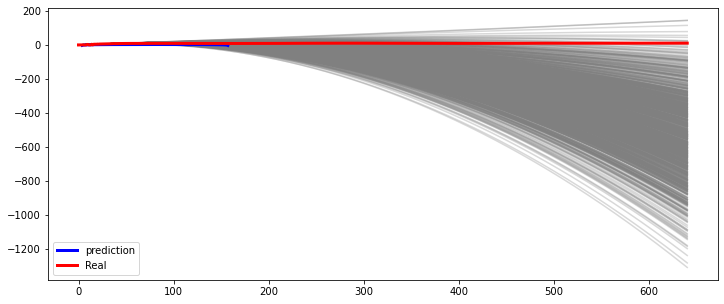

In [23]:
N_SAMPLES = 1000

plt.figure(figsize=(12, 5))
samples = np.random.multivariate_normal(cur_mu, cur_sigma, N_SAMPLES)
samples_preds = []
for (*w, b) in samples:
    model.coef_ = np.array(w)
    model.intercept_ = b
    sample_preds_train = model.predict(X_train)
    sample_preds_test = model.predict(X_test)
    sample_preds = np.concatenate([sample_preds_train, sample_preds_test])
    samples_preds.append(np.cumsum(np.exp(sample_preds)))
    plt.plot(sample_preds[:1000], c='grey', alpha=0.3)

samples_preds = np.array(samples_preds)
plt.plot(np.log(preds[:1000]), color='blue', linewidth=3, label='prediction')
plt.plot(np.log(y[:1000]), color='red', linewidth=3, label='Real')
plt.legend();

1 мая 216652 случаев, 10-процентиль: 108737, 90-процентиль: 375723
1 июня 8136167 случаев. 10-процентиль: 277392, 90-процентиль: 16341433
1 сентября 286926825209147 случаев, 10-процентиль: 284214, 90-процентиль: 436601075


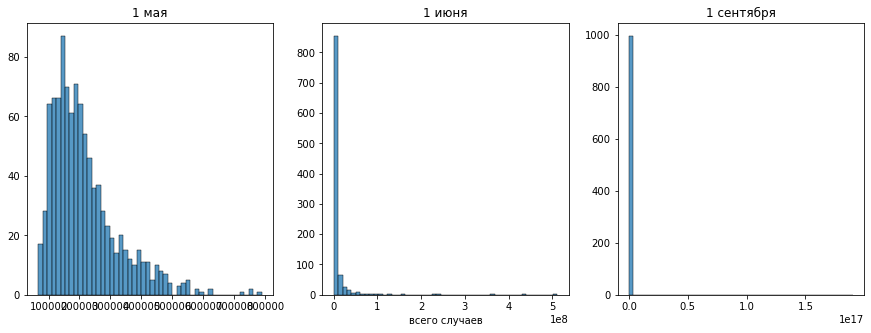

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
day_1 = pd.Timestamp('2020-05-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_1.days], bins=50, ax=ax[0]).set(title='1 мая', ylabel=None)

day_2 = pd.Timestamp('2020-06-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_2.days], bins=50, ax=ax[1]).set(title='1 июня', xlabel='всего случаев', ylabel=None)

day_3 = pd.Timestamp('2020-09-01') - pd.Timestamp('2020-03-03')
sns.histplot(samples_preds[:, day_3.days], bins=50, ax=ax[2]).set(title='1 сентября', ylabel=None);

print(
    f'1 мая {samples_preds[:, day_1.days].mean():.0f} случаев,',
    f'10-процентиль: {np.percentile(samples_preds[:, day_1.days], 10):.0f},', 
    f'90-процентиль: {np.percentile(samples_preds[:, day_1.days], 90):.0f}'
)
print(
    f'1 июня {samples_preds[:, day_2.days].mean():.0f} случаев.',
    f'10-процентиль: {np.percentile(samples_preds[:, day_2.days], 10):.0f},', 
    f'90-процентиль: {np.percentile(samples_preds[:, day_2.days], 90):.0f}'
)
print(
    f'1 сентября {samples_preds[:, day_3.days].mean():.0f} случаев,',
    f'10-процентиль: {np.percentile(samples_preds[:, day_3.days], 10):.0f},', 
    f'90-процентиль: {np.percentile(samples_preds[:, day_3.days], 90):.0f}'
)

Очевидно, что моделировать распространение вируса лишь по дням не самая лучшая мысль, однако даже в этом случае можно получить грубые оценки. Стоит заметить, что argmax сигмоидной модели почти совпал с реальными данными.